# Homework 4 

## Introduction

In this notebook I will explain the program I wrote for our fourth competiton. I used several methods to make the data given cleaner and better for using to train my model. I used single imputer to impute missing values and onehotencoder to transform categorical values to numerical ones. Then I used the training set to train my neural network, found the parameters that worked the best, and finalized the model which gives a closer prediction to our target.



## Problem Understanding


The objective of this project was to predict the target variable based on a syntetic train dataset. The dataset presented challenges such as missing values (null values) and mixed data types (non-numeric values), requiring robust preprocessing and feature engineering. The goal was to develop a reliable regression model that gave accurate predictions.


The first thing that I did was to import all the libraries that will be necessary for me to move further. Then I created two dataframes called "train" and "test" which includes the data that is given to us to work on.

The libraries I imported are used for these:

pandas and numpy: for data manipulation and numerical computations.

seaborn and matplotlib.pyplot: for data visualization.

sklearn modules: for machine learning processes, including preprocessing, splitting the data, building models, and evaluation.

scipy.stats: for statistical operations, such as calculating Z-scores for outlier detection.

imblearn.over_sampling.SMOTE: for handling class imbalance by generating synthetic samples.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Load data
train_data = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-04/train.csv')  # Replace with actual path
test_data = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-04/test.csv')    # Replace with actual path


## Data Visualization 

With the code below, I gained a general understanding of our dataset. Nearly all of our features have null variables which should be filled or dropped ,and the datatypes included are either a float or an object.

After preparing my X train full and y train full by assigning columns without target to X_train_full, and the target column itself to y_train_full; I created a plot showing the Distribution of the target variable, indicating the how many times a certain target value occurs.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          22500 non-null  int64  
 1   feature_01  20096 non-null  float64
 2   feature_02  19612 non-null  object 
 3   feature_03  20033 non-null  object 
 4   feature_04  20141 non-null  float64
 5   feature_05  20455 non-null  float64
 6   feature_06  19557 non-null  float64
 7   feature_07  19745 non-null  float64
 8   feature_08  20973 non-null  float64
 9   feature_09  19882 non-null  object 
 10  feature_10  20345 non-null  object 
 11  feature_11  19698 non-null  float64
 12  feature_12  19869 non-null  float64
 13  feature_13  19417 non-null  float64
 14  feature_14  21257 non-null  object 
 15  feature_15  20853 non-null  float64
 16  feature_16  20289 non-null  float64
 17  feature_17  19406 non-null  float64
 18  feature_18  21219 non-null  float64
 19  feature_19  21088 non-nul

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


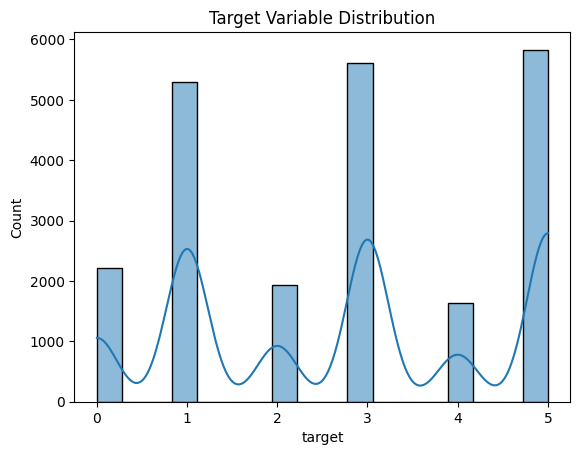

In [2]:

train_data.info()
train_data.describe()
train_data.head()

target_column = "target"
X_train_full = train_data.drop(columns=[target_column])
y_train_full = train_data[target_column]
X_test = test_data


import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.histplot(y_train_full, kde=True)
plt.title("Target Variable Distribution")
plt.show()

## Preparing The Data

I split the feature set into categorical and numerical columns. select_dtypes is used to identify categorical columns (i.e., columns with non-numeric data types). The other columns are considered numerical.

In [3]:

# Identify categorical columns
X = train_data.drop(columns=['target'])
categorical_columns = X.select_dtypes(include=['object']).columns  # Define categorical columns here
numerical_columns = X.select_dtypes(exclude=['object']).columns


Here I handled the missing values by imputing values.
I used SimpleImputer to fill in missing values:

For numerical columns, the missing values are replaced with the mean.

For categorical columns, missing values are replaced with the most frequent value.
The ColumnTransformer is used to apply different transformations (imputation) to numerical and categorical columns.

In [4]:
# Step 1: Handle missing values
# Impute missing values for numerical columns with mean and categorical with most frequent
imputer = ColumnTransformer(
    transformers=[('num', SimpleImputer(strategy='mean'), numerical_columns),
                  ('cat', SimpleImputer(strategy='most_frequent'), categorical_columns)]  # Now categorical_columns is defined
)

# Apply imputation to the training data
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(test_data)

# Convert imputed data back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=numerical_columns.tolist() + categorical_columns.tolist())
X_imputed_df.columns = X_imputed_df.columns.astype(str)  # Ensure all columns are strings

# Ensure that we are only working with numerical columns
numerical_data = X_imputed_df[numerical_columns]
# Ensure that numerical_data contains only numeric values
numerical_data = numerical_data.apply(pd.to_numeric, errors='coerce')

# Handle any NaN values that may have been introduced by conversion
numerical_data = numerical_data.fillna(numerical_data.mean())


I used Z-scores to detect the outliers. It finds how far off each data point is from the mean and data points with Z-scores higher than 3 are considered outliers. The outliers are handled in 2 ways :
1. Rows with Z-scores higher than 3 are removed. 
2. Outlier values are replaced with the 1st and 99th percentiles using np.clip.

In [5]:

# Step 1: Calculate Z-scores for outlier detection
z_scores = np.abs(stats.zscore(numerical_data))

# Option 1: Remove rows with outliers (z-score > 3)
outliers = (z_scores > 3)  # True means outlier
outliers_removed = numerical_data[~outliers.any(axis=1)]  # Remove rows where any feature is an outlier

# Option 2: Cap the outliers to the 1st and 99th percentiles
# Calculate the 1st and 99th percentiles
lower_bound = numerical_data.quantile(0.01)
upper_bound = numerical_data.quantile(0.99)

# Cap the outliers
numerical_data_capped = numerical_data.copy()
numerical_data_capped = numerical_data_capped.apply(lambda x: np.clip(x, lower_bound[x.name], upper_bound[x.name]))

# Now you can choose whether to continue with outliers_removed or numerical_data_capped
# Example: Continue with capped outliers for preprocessing
X_imputed_df[numerical_columns] = numerical_data_capped



As the feature engineering, I created a preprocessor with the column transformer. I used the Standard scaler for the numerical columns and the one hot encoder for the categorical columns. Which I explained below.

StandardScaler: Scales numerical features to zero mean and unit variance, making them suitable for algorithms like neural networks that are sensitive to feature scaling.

OneHotEncoder: Converts categorical variables into a one-hot encoded format (binary vectors), allowing the model to understand categorical data numerically.

In [6]:

# Step 2: Feature Engineering
# Apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_columns),
                  ('cat', OneHotEncoder(), categorical_columns)]
)

I applied the transformations (scaling for numerical and one-hot encoding for categorical columns) to the dataset using ColumnTransformer. The resulting data is stored as a sparse matrix, which we convert into a DataFrame for easier handling.

In [7]:

# Step 3: Preprocess the features (numerical and categorical)
X_preprocessed = preprocessor.fit_transform(X_imputed_df)

# Convert the preprocessed data to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed)

After preprocessing,I droped certain features identified by their indices. I determined these features via the importances plot which is placed later in the program. Since I already dropped the least important 14 features, the plot that is shown below plots the 15th to 25th least important features instead. 

In [8]:


# Drop the least important features by their numeric index after one-hot encoding
features_to_drop_indices = [28, 45, 27, 46, 16, 17,18,25,32,22, 33,39, 43, 48]

# Drop columns by their indices in the preprocessed DataFrame
X_preprocessed_df = X_preprocessed_df.drop(columns=X_preprocessed_df.columns[features_to_drop_indices], errors='ignore')

I split the given dataset into training and validation sets using train_test_split from sklearn.model_selection. This helps to validate the model on unseen data before final evaluation.

In [9]:

# Define X and y
X = train_data.drop(columns=['target'])  # Features (all columns except 'target')
y = train_data['target']  # Target variable

# Now split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42)


Since the dataset probably have imbalanced classes (I had underfitting and overfitting issues so I added this functions to reduce those effects), SMOTE (Synthetic Minority Over-sampling Technique) is applied to generate synthetic samples for the minority class, making the training data more balanced and helping the model learn better.

In [10]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## Exploratory Data Analysis

Then I created a random forest classifier to find the important features. I then fitted this model to my resampled train samples.

In [11]:

# Train a RandomForestClassifier for feature importance
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Here I used that model to find the feature importances and found the least important 10 features. Since I already dropped 14 least important features, the code below shows the ones after them and the plot has some features without values. 

    feature  importance
24       31    0.007120
26       35    0.007546
35       49    0.007859
34       47    0.008097
28       37    0.008134
33       44    0.008583
16       19    0.008662
23       30    0.008763
32       42    0.009164
30       40    0.009381


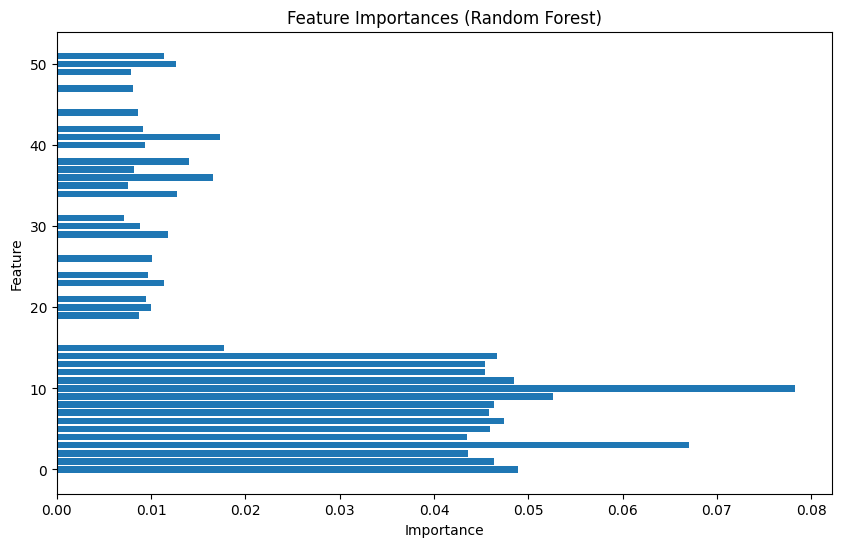

In [12]:

# Get feature importances
importances = model_rf.feature_importances_

# Create a DataFrame for feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)

# Print top 10 most important features
print(feature_importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()


## Solution Approach

I used a Multi-Layer Perceptron (MLP) Classifier to build a neural network. The model architecture is defined as:

hidden_layer_sizes: with 64 and 32 neurons.

activation: ReLU (Rectified Linear Unit) is used as the activation function to introduce non-linearity.

solver: Stochastic Gradient Descent (SGD) is chosen as the optimization algorithm.

alpha: Regularization term to prevent overfitting.

learning_rate_init: Initial learning rate.

momentum: Helps accelerate SGD in the relevant direction.

learning_rate: 'adaptive' adjusts the learning rate when the validation score is not improving.

I used cross-validation to evaluate the model's performance before fitting it. I used the F1 score , as specified in the homework overview, to measure the model's performance, balancing precision and recall.

I tried many different values for each of the hyperparameters and came to the conclusion that these values give the most accurate prediction I could get. 

In [13]:

model_nn = MLPClassifier(
    hidden_layer_sizes=( 64,32),
    activation='relu',
    solver='sgd',
    max_iter=2000,
    random_state=42,
    alpha=0.001,
    learning_rate_init=0.005,
    momentum=0.9,
    learning_rate='adaptive'
)


# Perform cross-validation to evaluate the model's performance
cross_val_f1 = cross_val_score(model_nn, X_train_resampled, y_train_resampled, cv=5, scoring='f1_micro')
print(f'Cross-validation F1 Score: {np.mean(cross_val_f1):.4f}')


Cross-validation F1 Score: 0.4922


I trained the final model with the resampled data, and I had the validation F1 score to see the model's performance with another evaluation.

In [14]:

# Train the model
model_nn.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = model_nn.predict(X_val)

# Evaluate the model using F1 score
f1 = f1_score(y_val, y_val_pred, average='micro')
print(f'Validation F1 Score: {f1:.4f}')


# Display detailed classification report
print("Classification Report for Validation Set:\n", classification_report(y_val, y_val_pred))

Validation F1 Score: 0.3036
Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.19      0.26      0.22       419
           1       0.37      0.35      0.36      1072
           2       0.16      0.24      0.19       388
           3       0.31      0.21      0.25      1142
           4       0.13      0.19      0.16       314
           5       0.44      0.42      0.43      1165

    accuracy                           0.30      4500
   macro avg       0.27      0.28      0.27      4500
weighted avg       0.32      0.30      0.31      4500



## Results Interpretation

The 0.4922 cross-validation F1 score showed me that the model is performing reasonably well when evaluated on multiple different training and validation splits. This suggests that the model may be capable of learning the patterns in the data, but the results do not perform this well with the validation set, as shown by the difference between the cross-validation and validation scores.

The 0.3036 F1 score on the validation set is lower than the cross-validation score, indicating that the model's performance is worse on unseen data, which is a sign of potential overfitting.

Even though I thought that increasing the aplha value in hyperparameter tuning would reduce the overfitting when I tried different hyperparameters I couldn't get a better F1 score. 

I had the test data undergo the same preprocessing steps as the training data. I created my submission file to submit as my final prediction. 

In [15]:

# Apply preprocessing to the test data
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=numerical_columns.tolist() + categorical_columns.tolist())
X_test_imputed_df.columns = X_test_imputed_df.columns.astype(str)

X_test_preprocessed = preprocessor.transform(X_test_imputed_df)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed)

# Drop columns from the test data
X_test_preprocessed_df = X_test_preprocessed_df.drop(columns=X_test_preprocessed_df.columns[features_to_drop_indices], errors='ignore')

# Now predict on the aligned test data
y_test_pred = model_nn.predict(X_test_preprocessed_df)

# Save predictions to CSV
submission = pd.DataFrame({'id': test_data['id'], 'target': y_test_pred})
submission.to_csv('submission.csv', index=False)

print('Submission file saved as "submission.csv"')


Submission file saved as "submission.csv"


## Conclusion:

This program I wrote handles data preprocessing (missing values, outliers, encoding, scaling), performs feature engineering, builds and tunes a neural network model, and evaluates it using cross-validation and F1 score. The SMOTE technique ensures that the model learns from a balanced dataset, and feature importance analysis helps refine the model further.  The model is trained on a well-prepared dataset, taking into account the complexity of the data. Each step plays a crucial role in improving the model’s performance and contributes to the success of the final submission.